Создать рекомендательную систему для прогнозирования
релевантного контента для каждого пользователя на основе его
предпочтений и истории.
Для решения этой задачи можно использовать различные алгоритмы и подходы, включая:
1. Коллаборативная фильтрация: Этот метод основывается на сходстве между пользователями и/или элементами контента. Использует информацию о предпочтениях и поведении других пользователей для прогнозирования
рекомендаций.
2. Контентная фильтрация: Этот подход анализирует характеристики контента (например, жанр, актеры, ключевые слова) и прогнозирует рекомендации на основе сходства между элементами контента и предпочтениями пользователя.
3. Гибридные методы: это комбинация коллаборативной фильтрации и контентной фильтрации, чтобы улучшить точность рекомендаций. Гибридные методы могут использовать различные веса и стратегии
комбинации информации о пользователе и контенте.
4. Машинное обучение: Методы машинного обучения могут
использоваться для построения моделей, которые могут прогнозировать рекомендации на основе исторических данных. Это может включать использование алгоритмов классификации, регрессии или нейронных сетей.

In [23]:
pip install scikit-surprise

In [24]:
import pandas as pd
from surprise import Dataset, Reader
from surprise import SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
import matplotlib.pyplot as plt

In [25]:
# Загрузка данных о друзьях
friends_data = pd.read_csv('friends.csv', delimiter='|')
# Загрузка данных о фильмах/сериалах
movie_info_data = pd.read_csv('movie_info.csv', delimiter='|')
# Загрузка данные об оценках фильмов/сериалов от пользователей
movie_votes_data = pd.read_csv('movie_votes.csv', delimiter='|')
series_votes_data = pd.read_csv('series_votes.csv', delimiter='|')

In [26]:
friends_data.head(5)

,person,friended
0,15647798,14858844
1,15647798,32741320
2,15647798,7099097
3,15647798,13634703
4,15647798,14031654


In [27]:
movie_info_data.head(5)

,id,type,genre,title_russian,title_original,production_year,countries,actors,director,writer,...,world_box,awards,rating_imdb_count,rating_imdb_value,rating_kinopoisk_count,rating_kinopoisk_value,rating_worldwide_critics_count,rating_worldwide_critics_value,duration,world_premiere
0,447301,Film,"['фантастика', 'боевик', 'триллер', 'драма', '...",Начало,Inception,2010.0,"['США', 'Великобритания']","['37859', '9867', '43503', '39984', '30759', '...",['41477'],['41477'],...,8.283220e+08,"['Оскар за Лучшая работа оператора', 'Оскар за...",2084916,8.8,749753,8.660,359,8.1,148,2010-07-08
1,361,Film,"['триллер', 'драма', 'криминал']",Бойцовский клуб,Fight Club,1999.0,"['США', 'Германия']","['25774', '25584', '25775', '14127', '25776', ...",['2944'],"['25773', '25772']",...,1.008538e+08,[],1869371,8.8,596063,8.641,177,7.4,139,1999-09-10
2,258687,Film,"['фантастика', 'драма', 'приключения']",Интерстеллар,Interstellar,2014.0,"['США', 'Великобритания', 'Канада']","['797', '38703', '1111242', '2007922', '3711',...",['41477'],"['55539', '41477']",...,6.778968e+08,['Оскар за Лучшие визуальные эффекты'],1529450,8.6,667884,8.600,366,7.1,169,2014-10-26
3,435,Film,"['фэнтези', 'драма', 'криминал', 'детектив']",Зеленая миля,The Green Mile,1999.0,['США'],"['9144', '12759', '22527', '677', '20664', '89...",['24262'],"['24262', '24263']",...,2.868014e+08,[],1158184,8.6,652888,9.061,134,6.8,189,1999-12-06
4,2213,Film,"['мелодрама', 'история', 'триллер', 'драма']",Титаник,Titanic,1997.0,"['США', 'Мексика', 'Австралия', 'Канада']","['37859', '21709', '45019', '379', '22961', '2...",['27977'],['27977'],...,2.127488e+09,"['Оскар за Лучший фильм', 'Оскар за Лучший реж...",1053998,7.8,546983,8.363,193,8.0,194,1997-11-01


In [28]:
movie_votes_data.head(5)

,user_id,movie_id,score,time
0,15647798,568289,9.0,1.542848e+09
1,15647798,435,8.0,1.542848e+09
2,15647798,535341,9.0,1.542848e+09
3,15647798,389,8.0,1.542848e+09
4,15647798,361,8.0,1.542848e+09


In [29]:
series_votes_data.head(5)

,user_id,movie_id,score,time
0,15647798,685246,9,1547690700
1,15647798,571335,10,1547693880
2,15647798,505748,6,1547693880
3,15647798,582358,8,1547693940
4,15647798,962012,7,1547694060


In [30]:
# Создание объекта Reader для определения диапазона оценок
reader = Reader(rating_scale=(1, 10))

In [31]:
# Загрузка данных в формате, понимаемый библиотекой surprise
movie_dataset = Dataset.load_from_df(movie_votes_data[['user_id', 'movie_id', 'score']], reader)
series_dataset = Dataset.load_from_df(series_votes_data[['user_id', 'movie_id', 'score']], reader)

In [32]:
# Разбиение данных на обучающий и тестовый наборы
trainset_movie, testset_movie = train_test_split(movie_dataset, test_size=0.2)
trainset_series, testset_series = train_test_split(series_dataset, test_size=0.2)

In [33]:
# Инициализация моделей SVD для фильмов и сериалов
model_movie = SVD(n_factors=100, lr_all=0.005, reg_all=0.02)
model_series = SVD(n_factors=100, lr_all=0.005, reg_all=0.02)

In [34]:
# Обучаем модели на обучающих наборах
model_movie.fit(trainset_movie)
model_series.fit(trainset_series)

In [35]:
# Получаем предсказания для тестовых наборов
predictions_movie = model_movie.test(testset_movie)
predictions_series = model_series.test(testset_series)

In [36]:
# Оцениваем качество моделей
rmse_movie = accuracy.rmse(predictions_movie)
mae_movie = accuracy.mae(predictions_movie)
print(f'RMSE for Movies: {rmse_movie}')
print(f'MAE for Movies: {mae_movie}')

rmse_series = accuracy.rmse(predictions_series)
mae_series = accuracy.mae(predictions_series)
print(f'RMSE for Series: {rmse_series}')
print(f'MAE for Series: {mae_series}')

RMSE: 3.5372
MAE:  2.9701
RMSE for Movies: 3.5372401045218553
MAE for Movies: 2.9701073981260047
RMSE: 1.5405
MAE:  1.1194
RMSE for Series: 1.5405045146754193
MAE for Series: 1.1193729094242717


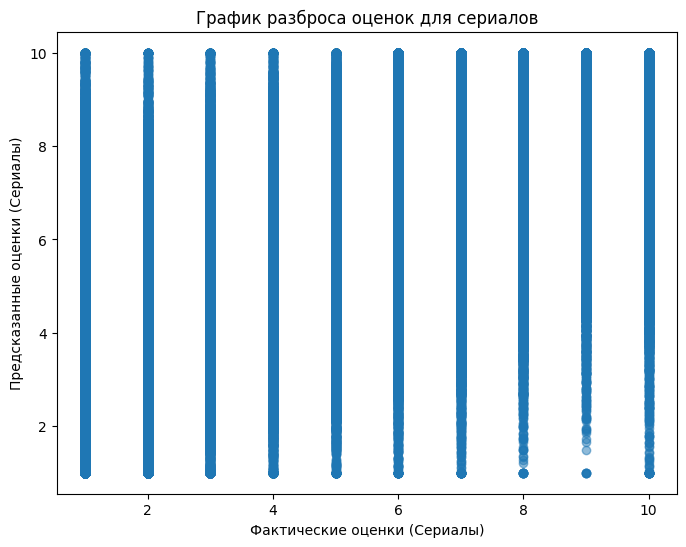

In [37]:
# График разброса оценок для сериалов
actual_ratings_series = [prediction.r_ui for prediction in predictions_series]
predicted_ratings_series = [prediction.est for prediction in predictions_series]

plt.figure(figsize=(8, 6))
plt.scatter(actual_ratings_series, predicted_ratings_series, alpha=0.5)
plt.xlabel('Фактические оценки (Сериалы)')
plt.ylabel('Предсказанные оценки (Сериалы)')
plt.title('График разброса оценок для сериалов')
plt.show()

In [39]:
# Рекомендации для пользователя
user_id = 14

all_movies_and_series = pd.concat([movie_info_data, series_votes_data], axis=1)
rated_movies_and_series = pd.concat([movie_votes_data, series_votes_data], axis=1)

unrated_movies_and_series = all_movies_and_series[~all_movies_and_series['id'].isin(rated_movies_and_series['movie_id'])]

user_predictions = []
for movie_id in unrated_movies_and_series['id']:
    prediction_movie = model_movie.predict(user_id, movie_id)  # Используем модель для фильмов
    prediction_series = model_series.predict(user_id, movie_id)  # Используем модель для сериалов
    combined_rating = (prediction_movie.est + prediction_series.est) / 2  # Усредненная оценка
    user_predictions.append((movie_id, combined_rating))

user_predictions.sort(key=lambda x: x[1], reverse=True)
top_N = 10
top_recommendations = user_predictions[:top_N]

print("Список топ-10 рекомендаций для пользователя")
for movie_id, estimated_rating in top_recommendations:
    recommended_movie_info = all_movies_and_series[all_movies_and_series['id'] == movie_id]
    print(f"Название: {recommended_movie_info['title_original'].values[0]}")
    print(f"Предполагаемый рейтинг: {estimated_rating}\n")

Список топ-10 рекомендаций для пользователя
Название: Life Story
Предполагаемый рейтинг: 9.736266775407085

Название: Planet Earth II
Предполагаемый рейтинг: 9.733387208032951

Название: Blue Planet II
Предполагаемый рейтинг: 9.715273413397984

Название: The World at War
Предполагаемый рейтинг: 9.70915564376099

Название: nan
Предполагаемый рейтинг: 9.707067673269478

Название: The Beatles Anthology
Предполагаемый рейтинг: 9.704300495868509

Название: Seven Worlds One Planet
Предполагаемый рейтинг: 9.694018629312293

Название: Unplugged
Предполагаемый рейтинг: 9.68095821734342

Название: Our Planet
Предполагаемый рейтинг: 9.678101749270407

Название: Cosmos: A Spacetime Odyssey
Предполагаемый рейтинг: 9.654513097858647



Список топ-10 рекомендаций для пользователя включает в себя разнообразные документальные и научно-популярные сериалы. Предполагаемые рейтинги для этих рекомендаций высокие, что может указывать на их релевантность для пользователя.